In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm.auto import trange

## Importation of data

Le data provient du repo suivant : https://github.com/chentianyi1991/LAG-code s

In [2]:
data = np.loadtxt("data/data2/data.txt")
data.shape

(351, 34)

In [3]:
y = np.loadtxt("data/data2/y.txt", dtype=int)
y.shape

(351,)

In [4]:
# StandardScaler : mean of 0 and std of 1
scaled_data = StandardScaler().fit_transform(data)

pca = PCA(2)
pca_data = pca.fit_transform(data)
pca_data.shape

(351, 2)

In [5]:
pca_df = pd.DataFrame(data=pca_data, columns=["PC1", "PC2"])
pca_df["y"] = y
pca_df

,PC1,PC2,y
0,-0.867272,-0.958255,0
1,0.758003,-1.062097,1
2,-1.125716,-0.387570,0
3,0.973920,0.591342,1
4,0.122603,-0.782209,0
...,...,...,...
346,-1.819980,-0.083363,0
347,-2.054370,0.067011,0
348,-2.016985,0.009466,0
349,-1.885884,-0.255541,0


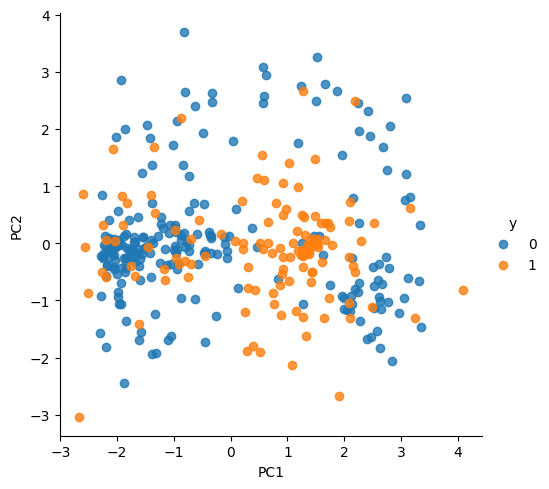

In [6]:
sns.lmplot(x="PC1", y="PC2", data=pca_df, hue="y", fit_reg=False, legend=True)

In [7]:
# Adding an intercept
temp_data = np.ones((data.shape[0], data.shape[1] + 1))
temp_data[:, 1:] = data
data = temp_data
data.shape

(351, 35)

In [8]:
d = data.shape[1]
d

35

## Logistic Regression

In [9]:
rho = 1

In [10]:
clf = LogisticRegression(
    penalty="l2", C=rho, fit_intercept=False, solver="liblinear"
).fit(data, y)
y_pred = clf.predict(data)
y_pred_proba = clf.predict_proba(data)
clf.score(data, y)  # compute accuracy

0.9173789173789174

In [11]:
opt_theta = clf.coef_
opt_theta

array([[ 3.04249901, -1.72424855,  0.        , -1.18907274, -0.37181708,
        -1.43032952, -1.10915357, -0.77681737, -1.28893777, -0.89537906,
        -0.25158944,  0.66021331,  0.15589249,  0.26879339, -0.51583684,
        -0.58910584,  0.24015313, -0.07112989, -0.64417666,  0.63878569,
        -0.06557567, -0.15942653,  1.76346952, -0.88590121, -0.45129751,
        -0.65804062, -0.45602977,  1.80769733,  0.1088636 , -0.51493269,
        -0.90442969, -0.6340666 ,  0.23134998,  0.3236267 ,  1.13257126]])

In [12]:
loss = log_loss(y, y_pred_proba, labels=[0, 1])
loss

0.2274219719721609

## GADMM not parallelized

In [13]:
K = 500  # number of iterations
M = 8  # number of workers
rho = 1

split_data = np.array_split(data, M)

In [14]:
len(split_data)

8

In [15]:
split_data[0].shape

(44, 35)

In [16]:
split_y = np.array_split(y, M)

In [17]:
len(split_y)

8

In [18]:
split_y[0].shape

(44,)

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [20]:
def f(theta, sample_data, sample_y):
    proba_pred = [
        sigmoid(np.inner(theta, sample_data[i])) for i in range(len(sample_y))
    ]
    # y_pred = [int(proba>0.5) for proba in proba_pred]

    return log_loss(sample_y, proba_pred, labels=[0, 1])

In [21]:
f(opt_theta, data, y)

0.2274219719721609

On a la même loss qu'avec sklearn, tout va bien !

---



In [22]:
# Initialisation
Theta = np.zeros((M, d))
Lamb = np.zeros((M, d))


def objective_function(
    theta_n,
    sample_data,
    sample_y,
    lamb_n,
    lamb_n_minus_1,
    theta_n_minus_1,
    theta_n_plus_1,
    rho,
):
    resul = f(theta_n, sample_data, sample_y)
    if theta_n_minus_1 is not None:
        resul += lamb_n_minus_1 @ (theta_n_minus_1 - theta_n)
        resul += (rho / 2) * ((theta_n_minus_1 - theta_n) ** 2).sum()
    if theta_n_plus_1 is not None:
        resul += lamb_n @ (theta_n - theta_n_plus_1)
        resul += (rho / 2) * ((theta_n - theta_n_plus_1) ** 2).sum()

    return resul

In [23]:
# Iterative procedure
df_log = []

for k in trange(K):
    # Step 1 : head workers
    for n in range(M):
        if n % 2 == 0:
            sample_data = split_data[n]
            sample_y = split_y[n]
            lamb_n = Lamb[n]
            lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
            theta_n_minus_1 = Theta[n - 1] if n > 0 else None
            theta_n_plus_1 = Theta[n + 1] if n < M else None
            res = minimize(
                objective_function,
                x0=Theta[n],
                args=(
                    sample_data,
                    sample_y,
                    lamb_n,
                    lamb_n_minus_1,
                    theta_n_minus_1,
                    theta_n_plus_1,
                    rho,
                ),
            )
            Theta[n] = res.x

    # Step 2 : tail workers
    for n in range(M):
        if n % 2 == 1:
            sample_data = split_data[n]
            sample_y = split_y[n]
            lamb_n = Lamb[n]
            lamb_n_minus_1 = Lamb[n - 1] if n > 0 else None
            theta_n_minus_1 = Theta[n - 1] if n > 0 else None
            theta_n_plus_1 = Theta[n + 1] if n < M - 1 else None
            res = minimize(
                objective_function,
                x0=Theta[n],
                args=(
                    sample_data,
                    sample_y,
                    lamb_n,
                    lamb_n_minus_1,
                    theta_n_minus_1,
                    theta_n_plus_1,
                    rho,
                ),
            )
            Theta[n] = res.x

    # Step 3 : Update lambda
    for n in range(M - 1):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - Theta[n + 1])

    for n in range(M):
        df_log.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log)

  0%|          | 0/500 [00:00<?, ?it/s]

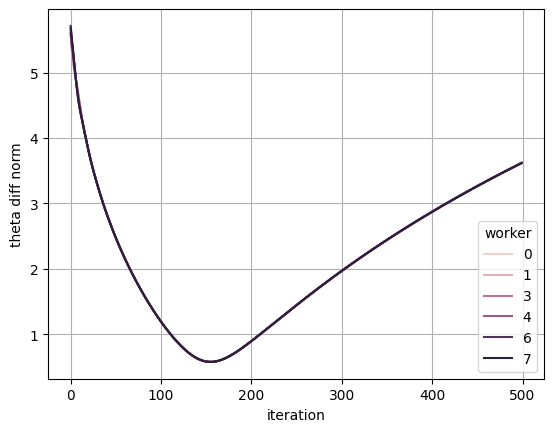

In [24]:
sns.lineplot(x="iteration", y="theta diff norm", data=df_log, hue="worker")
plt.grid()

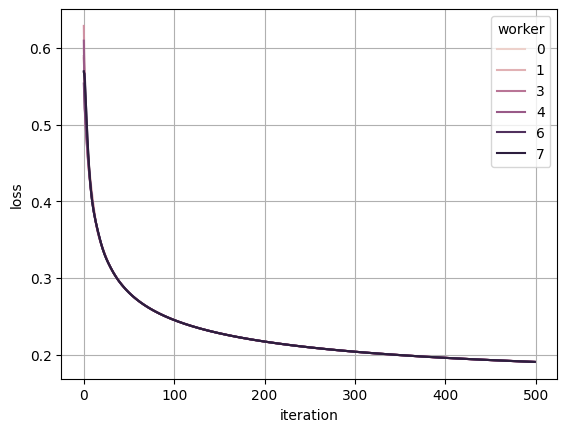

In [25]:
sns.lineplot(x="iteration", y="loss", data=df_log, hue="worker")
plt.grid()

In [26]:
Theta[0]

array([ 4.99133386e+00, -2.97214427e+00, -7.44485422e-06, -1.54414145e+00,
       -2.35187847e-01, -2.09890618e+00, -1.95548896e+00, -9.71152342e-01,
       -2.00944161e+00, -1.33872697e+00, -2.57633696e-01,  1.20218883e+00,
        4.43347543e-01,  4.66071992e-01, -7.69468962e-01, -1.13146132e+00,
        7.01556956e-01, -1.81581231e-01, -1.08838610e+00,  1.15818246e+00,
       -2.01643239e-02, -1.93290560e-01,  2.75389267e+00, -1.42332648e+00,
       -8.28810353e-01, -1.09538758e+00, -6.22249215e-01,  2.83925228e+00,
        1.22175709e-01, -9.32437738e-01, -1.63247452e+00, -9.54254016e-01,
        3.33024608e-01,  7.07589502e-01,  1.86773014e+00])

In [27]:
df_data = []
for n in range(M):
    df_data.append(
        {
            "worker": n,
            "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
            "loss": f(Theta[n], data, y),
        }
    )
pd.DataFrame(df_data)

,worker,theta diff norm,loss
0,0,3.617518,0.190374
1,1,3.617517,0.190374
2,2,3.617530,0.190374
3,3,3.617530,0.190373
4,4,3.617543,0.190373
5,5,3.617544,0.190373
6,6,3.617557,0.190373
7,7,3.617551,0.190373
